Neste notebook:
* Avaliação de usuários por bucket  
    * em média, e mediana, em quantos buckets os utilizadores estão.  
    * quantos usuários novos estão em cada bucket e quantos não ocorrem

Objetivo:
* explorar caracteristicas dos datasets que permitam
    * avaliar se o dataset é util para a análise  
    * escolher o número de buckets  

Vamos definir o numero de itens em cada bucket como 50k

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData
from recommenders_implicit import ISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout
from dataset_evaluation_utils import * #get_interactions_info, plot_interactions_per_month, plot_user_presence_distribution, plot_n_users_per_bucket, plot_bucket_size

from datetime import datetime, timedelta

import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
# Amazon Books
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


In [3]:
dataset_name = 'Amazon_Books'
user_col = 'user_id'

In [4]:
# data = pd.read_csv('output/amazonbooks_dump/sampled_amazon_books.csv')

In [5]:
# importa dataset 'amazon books'
data = pd.read_csv("../datasets/Books.csv", names=['user_id', 'item_id', 'rating', 'timestamp'])

In [6]:
data.shape

(51311621, 4)

In [7]:
data.head()

,user_id,item_id,rating,timestamp
0,0001713353,A1C6M8LCIX4M6M,5.0,1123804800
1,0001713353,A1REUF3A1YCPHM,5.0,1112140800
2,0001713353,A1YRBRK2XM5D5,5.0,1081036800
3,0001713353,A1V8ZR5P78P4ZU,5.0,1077321600
4,0001713353,A2ZB06582NXCIV,5.0,1475452800


In [8]:
# data['item_id'].nunique() # 15362619

### Keep only high ratings

<AxesSubplot:ylabel='Frequency'>

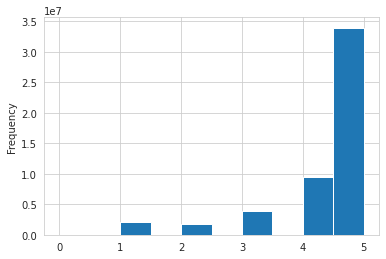

In [9]:
data['rating'].plot(kind='hist')

In [10]:
pos_ratings = np.quantile(data['rating'], q=0.8)

In [11]:
pos_ratings

5.0

In [12]:
data = data[ data['rating'] == pos_ratings ].drop(columns='rating')

In [13]:
# number of remaining cases
data.shape[0]

33979736

### Convert timestamp

In [14]:
%%time
# 56.6 s
data['date'] = data['timestamp'].apply(lambda x: datetime.fromtimestamp(x) ) # convert unix timestamp to date
data = data.sort_values(by='date') # sort by date

CPU times: user 1min 7s, sys: 5.34 s, total: 1min 12s
Wall time: 1min 13s


In [15]:
data.head()

,user_id,item_id,timestamp,date
3476836,0140125183,A2P9YDRHZTJMC3,833500800,1996-05-31
18394619,0876851898,A3CX6N6BFFV1NS,835315200,1996-06-21
12923138,0553092626,A3RTKL9KB8KLID,840240000,1996-08-17
890264,0045300232,A3RTKL9KB8KLID,843004800,1996-09-18
17596157,0806128887,A1G2W2C669C8GC,848016000,1996-11-15


In [16]:
data.tail()

,user_id,item_id,timestamp,date
51304223,B01G9NVTSI,AHJDHJFLP7CPD,1538265600,2018-09-30
51304951,B01GEXSYXQ,A18RHTVSMBC6SP,1538352000,2018-10-01
51309931,B01HB9Q7CW,A2UUXH691JARF3,1538352000,2018-10-01
51309500,B01H7ZJRNG,AEC2WVP8H25HF,1538438400,2018-10-02
51307743,B01GW712JW,A2ZXRFUDBCF5KR,1538438400,2018-10-02


In [17]:
%%time
# 7 min 28s
# keep year-month
data['date'] = data['date'].apply(lambda x: datetime.strptime( str(x.year)+'-'+str(x.month), '%Y-%m' ))

CPU times: user 7min 7s, sys: 6.63 s, total: 7min 13s
Wall time: 7min 19s


## Evaluating Time defined Buckets 

Sampling the dataset

In [18]:
%%time
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()

CPU times: user 24.1 s, sys: 906 ms, total: 25 s
Wall time: 24.8 s


<AxesSubplot:xlabel='date'>

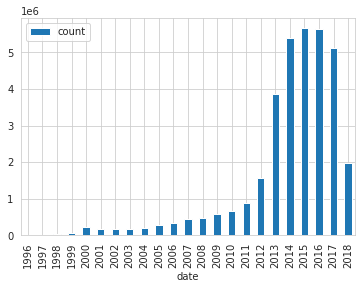

In [19]:
_ = interactions_per_month.copy()
_['date'] = _['date'].dt.year
_.groupby('date').sum().plot(kind='bar')

In [20]:
# y_filter = (data['date'] < datetime.strptime('2018', '%Y')) & (datetime.strptime('2014', '%Y') <= data['date']) 
# y_filter = (data['date'] < datetime.strptime('2015-01', '%Y-%m')) & (datetime.strptime('2014-01', '%Y-%m') <= data['date']) 
y_filter = (data['date'] < datetime.strptime('2014-04', '%Y-%m')) & (datetime.strptime('2014-01', '%Y-%m') <= data['date']) 

In [21]:
y_filter.sum()

1232207

In [22]:
data = data[y_filter.tolist()]

In [23]:
# number of remaining cases
data.shape[0]

1232207

**Sampling the dataset - only most frequent users**

In [24]:
%%time
# ( data[:1000000].groupby(by=['user_id'])['date'].nunique() > 1 ).sum()
user_freq_over_months = data.groupby(by=['user_id'])['date'].nunique()

CPU times: user 1.74 s, sys: 64.1 ms, total: 1.81 s
Wall time: 1.8 s


<AxesSubplot:ylabel='Frequency'>

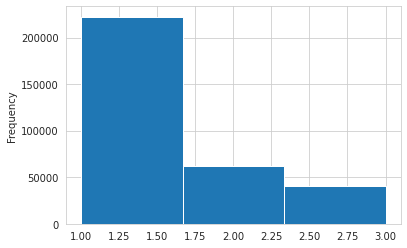

In [25]:
user_freq_over_months.plot(kind='hist',bins=user_freq_over_months.max())

In [26]:
# # # we'll filter users with frequency higher than q - only users that occur in every month for q = 1
# threshold = np.quantile(user_freq_over_months, q=0.8)
# threshold

In [27]:
# there are this many users with freq above the threshold
# (user_freq_over_months >= threshold).sum()

In [28]:
# index of frequent users
# freq_users = user_freq_over_months[user_freq_over_months >= threshold].index

In [29]:
# sample the dataset to contain only interactions from frequent users (that occur every month).
# there is still a huge number of interactions - 1694351
# _ = data.set_index('user_id').loc[freq_users]
# _.shape
_ = data.set_index('user_id').copy()

<AxesSubplot:>

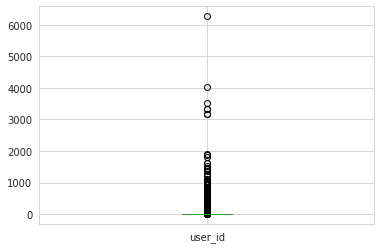

In [30]:
# frequency of users that occur every month:
_.reset_index()['user_id'].value_counts().plot(kind='box')

In [31]:
np.quantile(_.reset_index()['user_id'].value_counts(), 0.999)

189.2509999999893

In [32]:
# nu = int( _.reset_index()['user_id'].nunique()*0.0025 ) # 0.05% of users
threshold = np.quantile(_.reset_index()['user_id'].value_counts(), 0.999) #_.reset_index()['user_id'].value_counts().iloc[:nu].min() # sample 5% of users with highest freq, this freq is the threshold
freq_users = _.reset_index()['user_id'].value_counts()[ _.reset_index()['user_id'].value_counts() >= threshold ].index

In [33]:
# # sample again:
# # the frequency of the 500th user with most interactions is used as threshold
# threshold = _.reset_index()['user_id'].value_counts().iloc[:500].min()
# freq_users = _.reset_index()['user_id'].value_counts()[ _.reset_index()['user_id'].value_counts() >= threshold ].index

In [34]:
_.reset_index()['user_id'].value_counts()[ _.reset_index()['user_id'].value_counts() >= threshold ]

0007420412    6270
0141353678    4036
0345543246    3514
0439023521    3336
8184776217    3331
              ... 
1477805850     191
1530126894     191
0316176494     191
045141411X     190
0615849601     190
Name: user_id, Length: 325, dtype: int64

In [35]:
data['user_id'].nunique(), data['item_id'].nunique() # original number of users, original number of items

(324750, 788906)

In [36]:
_.loc[freq_users].reset_index()['user_id'].nunique(), _.loc[freq_users].reset_index()['item_id'].nunique() # sample number of users, and of items

(325, 124385)

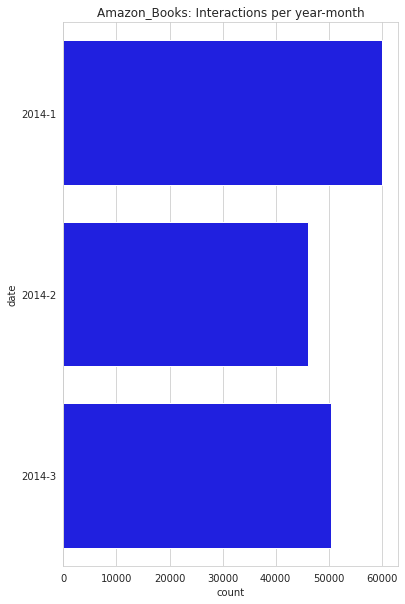

In [37]:
# %%time
plot_interactions_per_month(data=_.loc[freq_users].reset_index(), dataset_name=dataset_name)

In [38]:
# previous (huge) sample
# data = data.set_index('user_id').loc[freq_users].reset_index()
# new sample - only 500 most frequent users, from users that occur in every month
data = _.loc[freq_users].reset_index()

In [39]:
# number of remaining cases
data.shape[0]

156676

In [154]:
# sort by timestamp
# data = data.sort_values(by=['timestamp'])

In [41]:
# previous (huge) sample
# data.to_csv('output/amazonbooks_dump/sampled_amazon_books.csv', index=False)

# new sample
data.to_csv('output/amazonbooks_dump/3rd_sampled_amazon_books.csv', index=False)

How many interactions occur in each month / year?

CPU times: user 229 ms, sys: 8.03 ms, total: 237 ms
Wall time: 234 ms


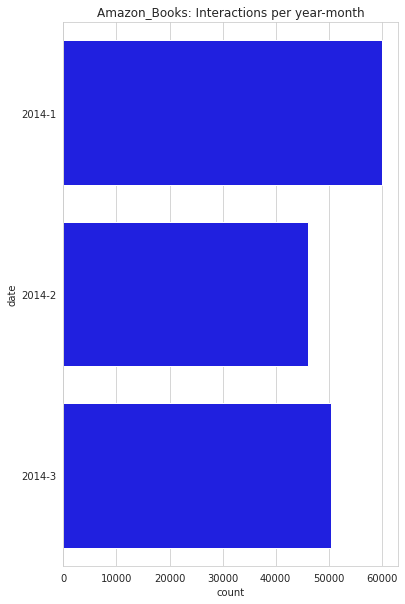

In [42]:
%%time
plot_interactions_per_month(data=data, dataset_name=dataset_name)

What is the user presence distribution based on month, quarter, and semester?

In [43]:
%%time
# 1.66s new sample time
# 1h 11s previous sample time
# user_presence_df, user_month_interactions, trimestres, user_trimestre_interactions, semestres, user_semestre_interactions = get_interactions_info(data=data, user_col=user_col)
user_presence_df, user_month_interactions, = get_interactions_info(data=data, user_col=user_col)

# previous huge sample
# user_presence_df.to_csv('output/amazonbooks_dump/user_presence_df.csv', index=False)
# user_month_interactions.to_csv('output/amazonbooks_dump/user_month_interactions.csv', index=False)

# new sample
user_presence_df.to_csv('output/amazonbooks_dump/3rd_sample_user_presence_df.csv', index=False)
user_month_interactions.to_csv('output/amazonbooks_dump/3rd_sample_user_month_interactions.csv', index=False)

# joblib.dump(trimestres, 'output/amazonbooks_dump/2nd_sample_trimestres.joblib' )
# user_trimestre_interactions.to_csv('output/amazonbooks_dump/2nd_sample_user_trimestre_interactions.csv', index=False)

0.0 %
20.0 %
40.0 %
60.0 %
80.0 %
CPU times: user 465 ms, sys: 3.85 ms, total: 469 ms
Wall time: 466 ms


In [158]:
# user_presence_df = pd.read_csv('output/amazonbooks_dump/user_presence_df.csv')
# user_month_interactions = pd.read_csv('output/amazonbooks_dump/user_month_interactions.csv')

In [44]:
user_presence_df.head()

,UserID,month_%
0,0002247399,1.0
1,006226303X,1.0
2,0120000156,1.0
3,1530126894,1.0
4,0091948177,1.0


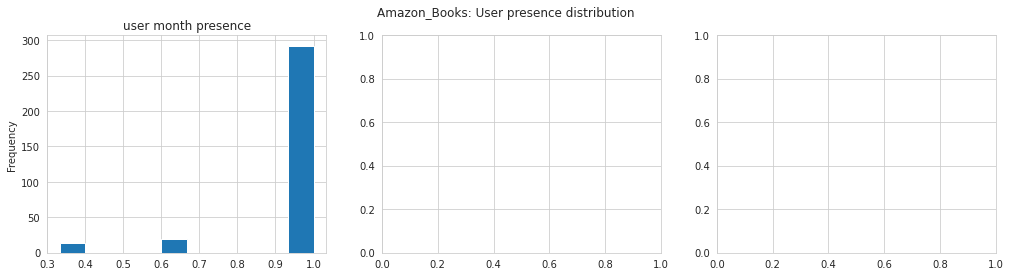

In [45]:
# plotting user frequency distribution
plot_user_presence_distribution(user_presence_df, dataset_name=dataset_name)

How many examples are there per quarter and semester?

In [47]:
# plot_interactions_per_qns(user_interactions=user_trimestre_interactions, date_range=trimestres, dataset_name=dataset_name, type_of_range='quarter')

In [48]:
# plot_interactions_per_qns(user_interactions=user_semestre_interactions, date_range=semestres, dataset_name=dataset_name, type_of_range='semester')

How many FREQUENT users (occur in 80% or more intervals) exist?

In [49]:
# defining threshold
frequency_threshold = 0.8

In [50]:
# frequent_users_month, frequent_users_trimestre, frequent_users_semestre = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)
frequent_users_month = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)

292 users of 325 (89.846%) occurr in 80.0% or more months.


In [51]:
# old huge sample
# joblib.dump(frequent_users_month, 'output/amazonbooks_dump/frequent_users_month.joblib')

# new sample
joblib.dump(frequent_users_month, 'output/amazonbooks_dump/3rd_sample_frequent_users_month.joblib')

['output/amazonbooks_dump/3rd_sample_frequent_users_month.joblib']

In median terms, how many times FREQUENT users appear in each quarter, and semester?

In [ ]:
# freq_user_quarter_info = get_frequent_user_statistics(
#     interactions_df=user_trimestre_interactions, frequent_users_list=frequent_users_trimestre)
# # freq_user_quarter_info

In [ ]:
# freq_user_quarter_info['median_freq_user_interactions'].plot(kind='bar')

In [ ]:
# freq_user_quarter_info['freq_users_at_least_1_interaction'].plot(kind='bar')

In [ ]:
# # frequent user interaction per quarter
# plot_interactions_per_qns(user_interactions=user_trimestre_interactions.loc[frequent_users_trimestre],
#     date_range=trimestres)

In [ ]:
# freq_user_semester_info = get_frequent_user_statistics(
#     interactions_df=user_semestre_interactions, frequent_users_list=frequent_users_semestre)
# # freq_user_semester_info

In [ ]:
# freq_user_semester_info['median_freq_user_interactions'].plot(kind='bar')

In [ ]:
# freq_user_semester_info['freq_users_at_least_1_interaction'].plot(kind='bar')

In [ ]:
# plot_interactions_per_qns(user_interactions=user_semestre_interactions.loc[frequent_users_semestre], date_range=semestres, type_of_range='semester')

In [ ]:
# # these are the users that should be used in holdouts, and only their last interactions
# # BUT, there are users that do not appear in some intervals, and some have only one interaction
# user_trimestre_interactions.loc[frequent_users_trimestre]
# user_semestre_interactions.loc[frequent_users_semestre];

## Evaluating Interactions 50E3 sized Buckets 

In [80]:
# n_iter_bucket = 50E3

# interval_start, interval_end = get_bucket_intervals(data, n_iter_bucket)    

How many users per bucket?    

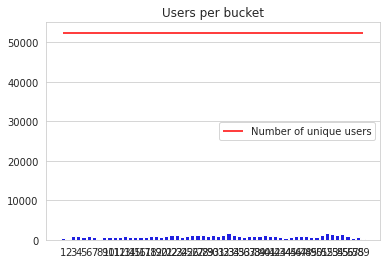

In [81]:
# plot_users_per_fixed_bucket(data, user_col, interval_start, interval_end)

How many FREQUENT users (occur in 80% or more intervals) exist?

In [83]:
# %%time
# # 2h 52min 2s
# user_bucket_interactions_df, dates_fixed_buckets_df = get_fixed_buckets_info(data, user_col, interval_start, interval_end)

CPU times: user 2h 52min 1s, sys: 1.53 s, total: 2h 52min 2s
Wall time: 2h 52min 2s


In [84]:
# frequency_threshold = 0.8

In [85]:
# frequent_users_bucket = get_frequent_users_fixed_buckets(user_bucket_interactions_df, frequency_threshold)

0 users of 52474 (0.0%) occur in 80.0% or more buckets.


In median terms, how many times FREQUENT users appear in each bucket?

In [86]:
# freq_user_bucket_info = get_frequent_user_statistics(user_bucket_interactions_df, frequent_users_bucket)

<AxesSubplot:>

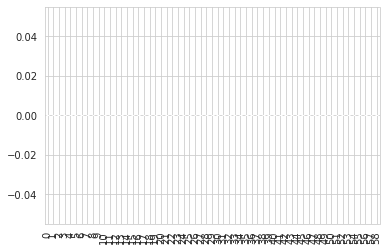

In [87]:
# freq_user_bucket_info['median_freq_user_interactions'].plot(kind='bar')

<AxesSubplot:>

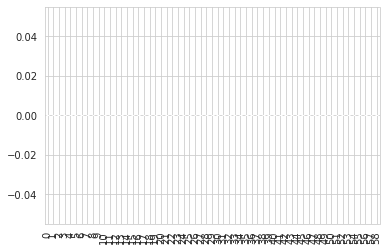

In [88]:
# freq_user_bucket_info['freq_users_at_least_1_interaction'].plot(kind='bar')

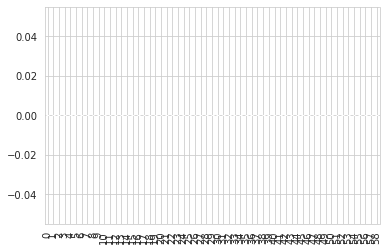

In [89]:
# frequent users interactions per bucket
# plot_user_interactions_per_bucket(user_bucket_interactions_df, frequent_users_bucket)

Which timestamps occur in each bucket?

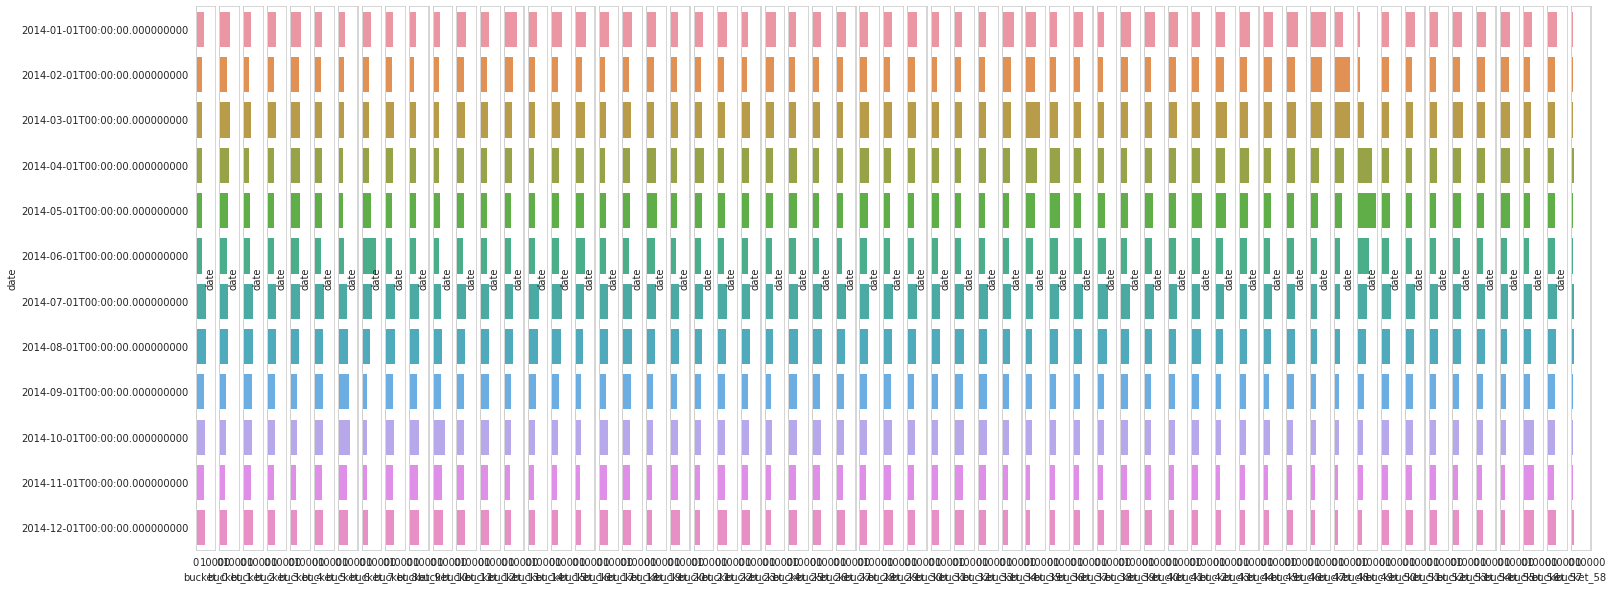

In [90]:
# plot_timestamps_per_bucket(dates_fixed_buckets_df)

___
## Store Buckets

In [ ]:
# # transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# # recebe listas
# stream = ImplicitData(data['user_id'], data['item_id'])

# empty_stream = ImplicitData([], [])

In [ ]:
# num_factors = 160
# num_iter = 4
# learn_rate = 0.5
# regularization = 0.4
# num_nodes = 8

In [ ]:
# # O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# # Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
# model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [ ]:
# n_holdouts = int( data.shape[0]/n_iter_bucket )
# eval_lastfm = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics = ["Recall@N"], N_recommendations=20, seed=42)

In [ ]:
# _=eval_lastfm.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 441 min

In [ ]:
# joblib.dump(eval_lastfm, 'output/joblib_bucket_info_dump/eval_lastfm', compress=True)